In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2
from utilities_namespace import *

In [2]:
%%capture
%load_ext rpy2.ipython
%R require(ggplot2)

In [4]:
from helpers.notebooks import notebooks_importer

In [5]:
%%capture
import Data as data

## Previously reported cancer stratification

On example of a well studied breast invasive carcinoma (BRCA) cohort from TCGA, as studied and reported by TCGA PanCancer Atlas in 2018.

In [6]:
from data_sources.pan_cancer_atlas import PanCancerAtlas

### PAM 50
- based on mRNA expression
- applied to breast cancer samples by (The Cancer Genome Atlas Network, 2012)

In [7]:
pam50_subtypes = PanCancerAtlas().subtypes_curated()

Please refer to https://www.bioconductor.org/packages/devel/bioc/vignettes/TCGAbiolinks/inst/doc/subtypes.html for the source of data for specific cohorts


In [8]:
pam50_brca = pam50_subtypes[pam50_subtypes.cancer_type == 'BRCA']

In [9]:
pam50_brca.dropna(axis=1).head()

,pan_samplesid,cancer_type,subtype_mrna,subtype_protein,subtype_selected,participant
407,TCGA-E2-A158-11A-22R-A12D-07,BRCA,Normal,-2147483648,BRCA.Normal,A158
408,TCGA-BH-A0DD-11A-23R-A12P-07,BRCA,LumA,-2147483648,BRCA.LumA,A0DD
409,TCGA-BH-A1EO-11A-31R-A137-07,BRCA,LumA,-2147483648,BRCA.LumA,A1EO
410,TCGA-BH-A0B5-11A-23R-A12P-07,BRCA,LumA,-2147483648,BRCA.LumA,A0B5
411,TCGA-A7-A13G-11A-51R-A13Q-07,BRCA,LumA,-2147483648,BRCA.LumA,A13G


For detailed description see: https://www.bioconductor.org/packages/devel/bioc/vignettes/TCGAbiolinks/inst/doc/subtypes.html

The *Subtype_Selected* column is equivalent to mRNA for BRCA:

In [10]:
assert ((pam50_brca.cancer_type + '.' + pam50_brca.subtype_mrna) == pam50_brca.subtype_selected).all()

While *Subtype_protein* has no variance at all:

In [11]:
pam50_brca.subtype_protein.unique()

array([-2147483648])

There are five subtypes in PAM 50 model:

In [12]:
pam50_brca.subtype_mrna.value_counts()

LumA      581
LumB      219
Basal     193
Normal    143
Her2       82
Name: subtype_mrna, dtype: int64

#### Coverage of PAM 50

There are subtypes assigned for every sample in BRCA cohort:

In [13]:
samples = set(data.brca_expression.columns)
pam_50_samples = set(pam50_brca.pan_samplesid)

In [14]:
len(samples & pam_50_samples) / len(samples)

1.0

#### PAM 50 allows to consider cancer heteregonity

Worth noting: in some cases there is more than one subtype per participant (which is kind of obvious when considering the cancer heterogeneity):

In [15]:
heterogenous = pam50_brca.groupby('participant').filter(lambda row: len(set(row.subtype_mrna)) > 1)

In [16]:
# ignore multiple samples (just look at the participants)
heterogenous_participants = heterogenous.drop_duplicates(subset=['participant', 'subtype_mrna'])[['participant', 'subtype_mrna']]

In [17]:
h = len(heterogenous_participants.participant.unique())
a = len(pam50_brca.participant.unique())
print(f'There are {h} participants (out of {a}) with heterogenity, so about {h/a*100:.2f}%')

There are 102 participants (out of 1097) with heterogenity, so about 9.30%


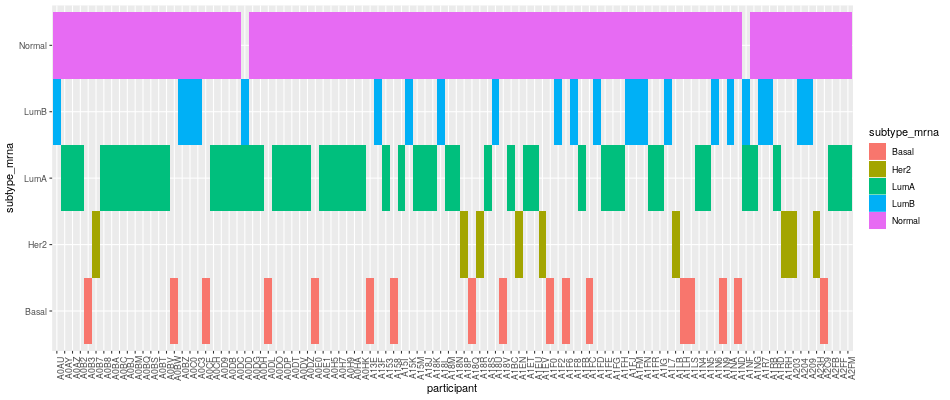

In [18]:
%%R -i heterogenous_participants -w 950 -h 400 -u px
(
    ggplot(heterogenous_participants, aes(x=participant, y=subtype_mrna, fill=subtype_mrna))
    + geom_tile()
    + theme(axis.text.x=element_text(angle=90))
)

In [19]:
heterogenous_groups = heterogenous_participants.groupby('participant').subtype_mrna.apply(lambda subtypes: ' and '.join(sorted(set(subtypes)))).to_dict()
heterogenous_participants['grouped'] = heterogenous_participants.participant.map(heterogenous_groups)
count_fraction = heterogenous_participants.groupby('participant').subtype_mrna.apply(lambda subtypes: 1/len(set(subtypes))).to_dict()
heterogenous_participants['Count'] = heterogenous_participants.participant.map(count_fraction)

In [20]:
heterogenous_participants = heterogenous_participants.sort_values('grouped')

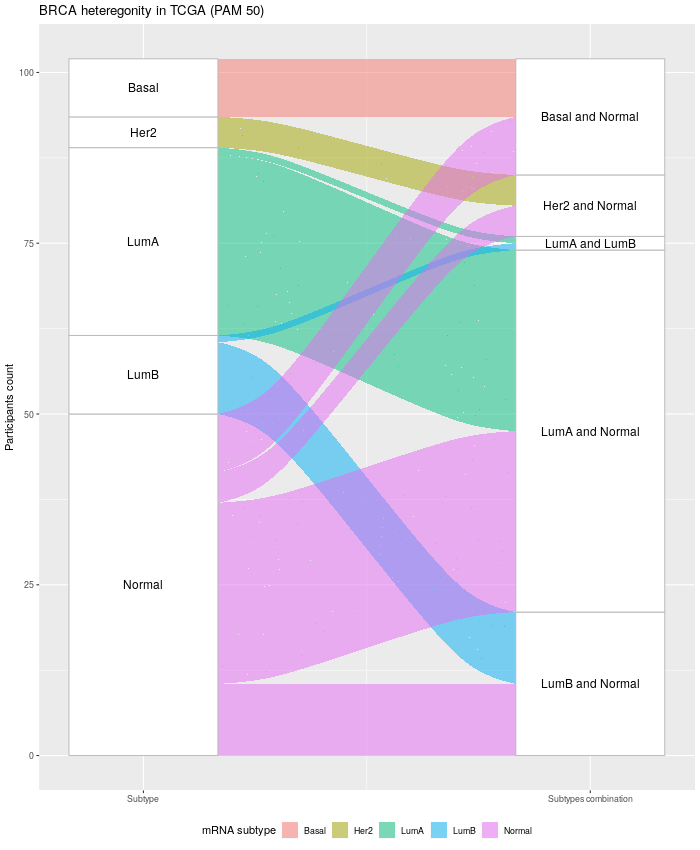

In [37]:
%%R -i heterogenous_participants -w 700 -h 850 -u px
require(ggalluvial)
(
    ggplot(heterogenous_participants, aes(axis1=subtype_mrna, axis2=grouped, y=Count))
    + geom_alluvium(aes(fill=subtype_mrna))
    + geom_stratum(width=1/3, fill='white', color = 'grey')
    + ggfittext::geom_fit_text(stat='stratum', label.strata=T, min.size=3, width=1/4)
    + scale_x_continuous(breaks=1:2, labels = c('Subtype', 'Subtypes combination'))
    + ylab('Participants count')
    + ggtitle('BRCA heteregonity in TCGA (PAM 50)')
    + labs(fill='mRNA subtype')
    + theme(legend.position='bottom')
)

### iCluster
- based on copy number, DNA methylation, mRNA and miRNA
- applied to all cancer types (pan-cancer clustering) by (Hoadley et al., 2018).

In [38]:
icluster_subtypes = PanCancerAtlas().icluster()

In [39]:
icluster_subtypes.icluster = 'IC' + icluster_subtypes.icluster.astype(str)

In [40]:
participants_with_brca = {
    barcode.participant
    for barcode in data.brca_expression.barcodes
}

In [41]:
icluster_brca = icluster_subtypes[icluster_subtypes.participant.isin(participants_with_brca)]

In [42]:
icluster_brca.head()

,sample_id,icluster,participant
4759,TCGA-3C-AAAU,IC19,AAAU
4760,TCGA-3C-AALI,IC2,AALI
4761,TCGA-3C-AALJ,IC17,AALJ
4762,TCGA-3C-AALK,IC2,AALK
4763,TCGA-4H-AAAK,IC19,AAAK


Some subtypes are assigned to only few (or even one) participants. Those may be mis-classifications or patients with metastasis (or just multiple cancers).

In [43]:
# upper numbers = custers, lower row = participants counts
HorizontalNamespace(icluster_brca.icluster.value_counts())

IC19,IC17,IC2,IC20,IC13,IC25,IC14,IC10,IC27,IC8,IC7,IC3,IC23,IC1,IC22
553,125,98,78,68,39,17,16,10,10,9,4,1,1,1


For the analysis I will exclude clusters with less than 3 samples (required number of samples for differential expression with signal-to-ratio and tTest metrics):

In [44]:
samples_by_participant = data.brca_expression.samples_by_participant()

In [45]:
def sampels_count_in_cluster(participants):
    return sum([
        len(samples_by_participant[participant])
        for participant in participants
    ])

In [46]:
sampels_in_cluster = icluster_brca.groupby('icluster').participant.apply(sampels_count_in_cluster)

In [47]:
# upper numbers = custers, lower row = samples counts
HorizontalNamespace(sampels_in_cluster)

IC1,IC10,IC13,IC14,IC17,IC19,IC2,IC20,IC22,IC23,IC25,IC27,IC3,IC7,IC8
2,18,75,20,136,620,108,84,1,1,44,11,4,11,11


In [48]:
selecetd_clusters = set(sampels_in_cluster[sampels_in_cluster > 3].index)
icluster_brca_selected = icluster_brca[icluster_brca.icluster.isin(selecetd_clusters)]

In [49]:
# upper numbers = custers, lower row = participants counts
HorizontalNamespace(icluster_brca_selected.icluster.value_counts())

IC19,IC17,IC2,IC20,IC13,IC25,IC14,IC10,IC27,IC8,IC7,IC3
553,125,98,78,68,39,17,16,10,10,9,4


#### Coverage of iCluster subtypes

The coverage is high when all subtypes are included (94.24%)

In [50]:
participants_icluster = set(icluster_brca.participant)
len(participants_with_brca & participants_icluster) / len(participants_with_brca)

0.9423604757548033

And remains comparable (93.96%) after exclusion of the three small clusters:

In [51]:
participants_icluster_selected = set(icluster_brca_selected.participant)
len(participants_with_brca & participants_icluster_selected) / len(participants_with_brca)

0.939615736505032

### PARADIGM
- based on mRNA expression, copy number and pathway interaction data (NCIPID, BioCarta, Reactome),
- "PARADIGM pathway analysis followed by unsupervised consensus clustering of pathway scores that clustered samples primarily by tissue type"
- applied to gynecologic and breast cancers by (Berger et al., 2018),

Methodology extracts (open access, [CC BY-NC-ND 4.0](https://creativecommons.org/licenses/by-nc-nd/4.0/), Berger et al):

> The PARADIGM algorithm infers an integrated pathway level (IPL) for each feature that reflects the log likelihood of the probability that it is activated (vs. inactivated). PARADIGM IPLs of the 19504 features within the SuperPathway is available on Synapse (syn6171376).

> We also computed the single sample gene set enrichment (ssGSEA) score, as described by Barbie et al (Barbie et al., 2009), of the constituent pathways forming the SuperPathway structure from the PARADIGM IPL data using the GSVA package in R (Hänzelmann et al., 2013). Of the 1524 pathways obtained, only 1387 have pathway members within the interconnected SuperPathway structure; and their ssGSEA scores are available on Synapse (syn10184122).

> Consensus Clustering based on PARADIGM Inferred Pathway Activation
Consensus clustering based on the 4876 most varying features (i.e. IPLs with variance within the highest quartile) was used to identify Pan-Gynecological subtypes implicated from shared patterns of pathway inference. Consensus clustering was implemented with the ConsensusClusterPlus package in R (Wilkerson and Hayes, 2010)

In [53]:
brca_subtypes_integrative = PanCancerAtlas().subtypes_integrative('BRCA')

In [54]:
# just to avoid confusion with Pan-Gyn clusters names
brca_subtypes_integrative.paradigm_clusters = 'PR' + brca_subtypes_integrative.paradigm_clusters

In [55]:
paradigm_brca = brca_subtypes_integrative.dropna(subset=['paradigm_clusters'])

In [56]:
HorizontalNamespace(paradigm_brca.paradigm_clusters.value_counts())

PRC5,PRC6,PRC4,PRC8,PRC2,PRC1,PRC7
356,271,247,103,75,1,1


Clusters with less than 3 samples are (again) excluded:

In [57]:
sampels_in_cluster = paradigm_brca.groupby('paradigm_clusters').participant.apply(sampels_count_in_cluster)

In [58]:
selecetd_clusters = set(sampels_in_cluster[sampels_in_cluster > 3].index)
paradigm_brca_selected = paradigm_brca[paradigm_brca.paradigm_clusters.isin(selecetd_clusters)]

In [59]:
HorizontalNamespace(paradigm_brca_selected.paradigm_clusters.value_counts())

PRC5,PRC6,PRC4,PRC8,PRC2
356,271,247,103,75


#### Coverage of PARADIGM clustering

Is again, high: 96.07%

In [60]:
participants_paradigm = set(paradigm_brca_selected.participant)
len(participants_with_brca & participants_paradigm) / len(participants_with_brca)

0.9606587374199451

### Cluster of Cluster Assignments (CoCA) integrative analysis

> We used cluster assignments from the six major TCGA platforms (mutations, SCNA, DNA methylation, mRNA, miRNA, and protein) to perform integrated clustering across the Pan-Gyn cohort using the CoCA algorithm. 

> The resulting CoCA clusters were heavily dominated by tumor type because the intrinsic gene expression patterns were lineage dependent. The association with tumor type was especially prominent in the DNA methylation, mRNA, miRNA, and protein clusters.

> Therefore, we turned to an alternative method (described next) to define subtypes that would span the Pan-Gyn tumor types and emphasize high-level similarities among them.

It seems that the CoCA clusters are not included (which seems ok, given that related figure only made it to supplementary files), but there are clusterings for each of the molecular platforms! So I could re-use these (but looking at BRCA only) and possibly get something interesting. Actually, there are many interesting ways of doing the consensus clustering...

But lets skip it for now as there are more pressing matters.

### Subtypes across the Pan-Gyn Tumors
> We present molecular subtypes that illuminate commonalities and distinguishing features across the Pan-Gyn tumor types, with the potential to inform future cross-tumor-type therapies. We first identified 16 features (listed in the STAR Methods) across 1,956 samples that were either (1) currently used in the clinic for at least 1 of the 5 tumor types, or (2) identified as informative in previous TCGA gynecologic and breast cancer studies

this is less granular clustering than PAM 50, but captures similarities on a higher level (as other gynecologic tumours were considered as well). Two examples, just to give an idea of the cluster meanings:

> SCNA load was the predominant feature and produced the first division. In the low-SCNA-load group, we found two clusters, non-hypermutator (C1) and hypermutator (C2). The non-hypermutator cluster had virtually no hypermutators but had high levels of ER+, PR+, and/or AR+ samples, indicating potential susceptibility to hormone therapies. C2, the hypermutator cluster, could be further subdivided into four subclusters (clusters C2A-C2D).

Sanity check: this clustering should have five clusters: C1-C5

In [61]:
pan_gyn_clusters_brca = brca_subtypes_integrative.dropna(subset=['pan_gyn_clusters'])

In [62]:
HorizontalNamespace(pan_gyn_clusters_brca.pan_gyn_clusters.value_counts())

C1,C3,C5,C4,C2
300,198,183,144,52


#### Coverage of Pan-Gyn

For pan-gyn clusters the coverage is relatively low (79.78% participants);

In [63]:
participants_pan_gyn = set(pan_gyn_clusters_brca.participant)
len(participants_with_brca & participants_pan_gyn) / len(participants_with_brca)

0.797804208600183

### Summary

Only curated PAM 50 subtypes are sample specific. Clusters from other papers are assigned to participants (patients), not to samples - which kind of makes sense, once we combine information from different omics we no longer have a single sample (unless we could match e.g. DNA/expression samples). But then the heterogeneity information is lost as well - which means that for about 10% of participants the explanations will be incomplete.

Stratification overview:

In [64]:
# adaptation for plot

In [65]:
pam50_adapted = pam50_brca[['participant', 'subtype_mrna']].drop_duplicates()
pam50_adapted.subtype_mrna = pam50_adapted.participant.map(heterogenous_groups).fillna(pam50_adapted.subtype_mrna)

In [66]:
pam50_adapted.head()

,participant,subtype_mrna
407,A158,Basal and Normal
408,A0DD,LumA and LumB
409,A1EO,LumA
410,A0B5,LumA
411,A13G,LumA


In [67]:
considered_stratifications = {
    'subtype_mrna': pam50_adapted,
    'icluster': icluster_brca_selected,
    'paradigm_clusters': paradigm_brca_selected,
    'pan_gyn_clusters': pan_gyn_clusters_brca,    
}

In [68]:
all_stratifications = concat([
    df.rename({custering_name: 'cluster'}, axis=1)[['participant', 'cluster']].drop_duplicates().assign(group=custering_name)
    for custering_name, df in considered_stratifications.items()
]).sort_values(['group', 'cluster'])

In [69]:
from helpers.plots.alluvium import suggest_groups_ordering, determine_order_for_clusters_in_groups

In [70]:
ordering_ranking = suggest_groups_ordering(all_stratifications)
ordering_ranking.head()

subtype_mrna       paradigm_clusters  pan_gyn_clusters   icluster             0.653327
paradigm_clusters  subtype_mrna       icluster           pan_gyn_clusters     0.653327
subtype_mrna       icluster           pan_gyn_clusters   paradigm_clusters    0.626636
icluster           subtype_mrna       paradigm_clusters  pan_gyn_clusters     0.626636
paradigm_clusters  subtype_mrna       pan_gyn_clusters   icluster             0.572720
dtype: float64

I am choosing the first one (additional benefit of having the curated, well established PAM 50 on the left side)

In [71]:
order = ordering_ranking.index[0]

In [72]:
# clusters in the PAM 50 groups should be ordered by similarity (when possible) (so do not separate clusters that are similar).
# Globally impossible, so lets evaluate combinations to elimiate the worst cases:
from itertools import combinations, permutations
pam_50 = all_stratifications[all_stratifications.group == 'subtype_mrna']
ranked_permutations = {}
for permutation in permutations(pam_50.cluster.unique()):
    score = 0
    for i, current in enumerate(permutation[1:], 1):
        previous = permutation[i - 1]
        if previous in current.split(' and ') or current in previous.split(' and '):
            score += 1
    ranked_permutations[permutation] = score

In [73]:
chosen_pam_order = Series(ranked_permutations).sort_values(ascending=False).index[0]

In [74]:
%%skip_on_import
all_group_orders = [
    *chosen_pam_order,
    *determine_order_for_clusters_in_groups(all_stratifications, order, chosen_pam_order)
]

100%|██████████| 3/3 [05:56<00:00, 107.01s/it]


In [75]:
from helpers.plots.colors import generate_colors, mix_colors, propagate_colors

In [76]:
single_clusters_pam_50 = pam50_brca.subtype_mrna.unique()

In [77]:
colors = generate_colors(single_clusters_pam_50)
HorizontalNamespace(colors)

Normal,LumA,Her2,LumB,Basal
#db5f57,#b9db57,#57db94,#5784db,#c957db


In [78]:
colors = mix_colors(colors, single_clusters_pam_50)
HorizontalNamespace(colors)

Normal,LumA,Her2,LumB,Basal,LumA and Normal,Her2 and Normal,LumB and Normal,Basal and Normal,Her2 and LumA,LumA and LumB,Basal and LumA,Her2 and LumB,Basal and Her2,Basal and LumB
#db5f57,#b9db57,#57db94,#5784db,#c957db,#cba957,#a7a979,#a773a7,#d25ba7,#91db79,#91b5a7,#c1a7a7,#57b5bb,#9ba7bb,#9b70db


In [79]:
colors = propagate_colors(colors, order, all_stratifications)

In [81]:
def colors_generation_piepline(labels, data, scale):
    colors = generate_colors(labels, scale=scale)
    colors = mix_colors(colors, labels)
    colors = propagate_colors(colors, order, data)
    return colors

In [95]:
from functools import partial
import matplotlib
from plotnine import scales
from helpers.plots.colors import CustomPalette, display_scales
from helpers.plots.alluvium import suggest_contrastive_colors

In [89]:
%%skip_on_import
qualitative_scales = [
    scales.scale_color_discrete(),
    *[
        scales.scale_color_brewer(type='qual', palette=i) for i in range(9)
    ],
    *[
        scales.scale_color_cmap_d(name=key)
        for key, value in matplotlib.cm.cmap_d.items()
        if isinstance(value, matplotlib.colors.ListedColormap)
    ]
]

scales_ranking = suggest_contrastive_colors(
    qualitative_scales,
    partial(colors_generation_piepline, single_clusters_pam_50, all_stratifications),
    {
        group_name: all_stratifications[all_stratifications.group == group_name]
        for group_name in all_stratifications.group.unique()
    }
)

100%|██████████| 56/56 [00:17<00:00,  3.38it/s]


In [91]:
%%skip_on_import
ranked_color_scales = Series(scales_ranking).sort_values(ascending=False)

In [93]:
ranked_color_scales.head()

<plotnine.scales.scale_color.scale_color_cmap_d object at 0x7f70ec768ac8>    1.799148e+06
<plotnine.scales.scale_color.scale_color_cmap_d object at 0x7f70ec768dd8>    1.622279e+06
<plotnine.scales.scale_color.scale_color_cmap_d object at 0x7f70ec768240>    1.510403e+06
<plotnine.scales.scale_color.scale_color_cmap_d object at 0x7f7139068c88>    1.463103e+06
<plotnine.scales.scale_color.scale_color_hue object at 0x7f70ec7537f0>       1.365764e+06
dtype: float64

In [96]:
display_scales(ranked_color_scales.head())

NeatNamespace(1365764.2852311875=HorizontalNamespace(0=<Color #db5f57>, 1=<Color #b9db57>, 2=<Color #57db94>, 3=<Color #5784db>, 4=<Color #c957db>), 1463102.6459719879=HorizontalNamespace(0=<Color #440154>, 1=<Color #3b528b>, 2=<Color #21918c>, 3=<Color #5cc863>, 4=<Color #fde725>), 1510403.4077567444=HorizontalNamespace(0=<Color #000004>, 1=<Color #51127c>, 2=<Color #b73779>, 3=<Color #fb8761>, 4=<Color #fcfdbf>), 1622279.374351116=HorizontalNamespace(0=<Color #000004>, 1=<Color #57106e>, 2=<Color #bc3754>, 3=<Color #f98c0a>, 4=<Color #fcffa4>), 1799147.6911516122=HorizontalNamespace(0=<Color #0d0887>, 1=<Color #7e03a8>, 2=<Color #cc4778>, 3=<Color #f89441>, 4=<Color #f0f921>))

I will slightly modify the first sclae (to workaround the very dark colour)

In [103]:
%%skip_on_import
colors = colors_generation_piepline(
    single_clusters_pam_50, all_stratifications,
    scale=CustomPalette(['#dafdf5', '#7e03a8', '#cc4778', '#f89441', '#f0f921'])
    # alternative: ranked_color_scales.index[4]
)

In [104]:
hex_colors = {label: color.to_hex() for label, color in colors.items()}

In [105]:
from rpy2.robjects import StrVector

r_colors = StrVector(list(hex_colors.values()))
r_colors.names = list(hex_colors.keys())

In [106]:
%%skip_on_import
all_stratifications.group = pd.Categorical(all_stratifications.group, ordered=True, categories=order)
assert set(all_group_orders) == set(all_stratifications.cluster.unique())
all_stratifications.cluster = pd.Categorical(all_stratifications.cluster, ordered=True, categories=all_group_orders)

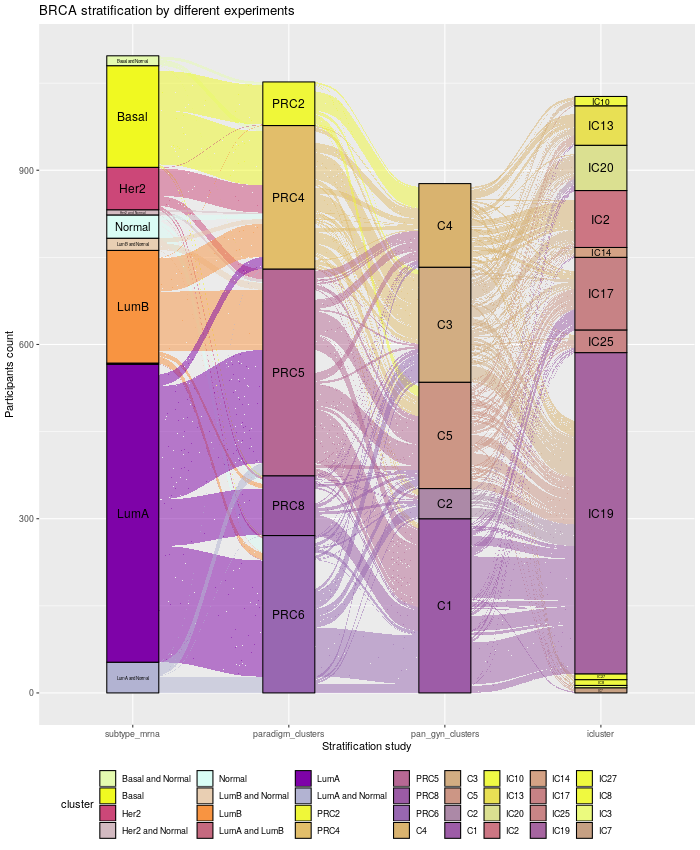

In [113]:
%%R -i all_stratifications -w 700 -h 850 -u px -i r_colors
require(ggalluvial)

(
    ggplot(all_stratifications, aes(x=group, stratum=cluster, alluvium=participant, fill=cluster))
    + geom_flow(stat="alluvium", lode.guidance="leftright")
    + geom_stratum()
    + scale_fill_manual(values=r_colors)
    + theme(legend.position='bottom')
    + ggfittext::geom_fit_text(stat='stratum', label.strata=T, min.size=3, width=1/4)
    + ylab('Participants count')
    + xlab('Stratification study')
    + ggtitle('BRCA stratification by different experiments')
    + guides(fill=guide_legend(ncol=10)) # TODO: maybe remove the legend
)